Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [15]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, 24h-delayed noise is added. Datetime columns are dropped in order to run model.

In [16]:
df = pd.read_csv("C://Users/saaan/Downloads/repositories/MDA/ModernDataAnalyticsProject/final_df.csv", delimiter=";")
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df['255442'] = df['object_id']==255442
df['255443'] = df['object_id']==255443
df['255444'] = df['object_id']==255444
df['255445'] = df['object_id']==255445
df['280324'] = df['object_id']==280324
df['303910'] = df['object_id']==303910
df = df.sort_values(by=['result_timestamp','object_id'])


In [17]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')


In [18]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(days=1)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\saaan\AppData\Local\Temp\ipykernel_11612\727566501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\saaan\AppData\Local\Temp\ipykernel_11612\727566501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\saaan\AppData\Local\Temp\ipykernel_11612\727566501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [19]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df= pd.merge(df,df_weatherdelay, on='key',validate='1:1')
df_nd = df.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [20]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
255442           0
255443           0
255444           0
255445           0
280324           0
303910           0
laeq_delayed     0
LC_HUMIDITY     43
LC_DWPTEMP      43
LC_n            43
LC_RAD          43
LC_RAININ       43
LC_DAILYRAIN    43
LC_WINDDIR      43
LC_WINDSPEED    43
LC_RAD60         4
LC_TEMP_QCL0    43
dtype: int64

In [21]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
255442          0
255443          0
255444          0
255445          0
280324          0
303910          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [22]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created.

In [64]:
y = df_nd["laeq"]
X = df_nd.drop("laeq", axis="columns")

In [24]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=38880,
    max_train_size=66000,
    test_size=30000,
)

In [25]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
75280,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75281,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75282,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75283,13,5,4,True,True,False,True,False,False,False,...,56.0,8.57,32.0,92.0,0.0,0.0,-44.0,0.05,492.0,17.57
75284,13,5,4,True,True,False,False,False,True,False,...,56.0,8.57,32.0,92.0,0.0,0.0,-44.0,0.05,492.0,17.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141275,1,1,6,False,False,True,False,False,False,False,...,82.0,11.85,31.0,0.0,0.0,0.0,111.0,0.05,0.0,14.76
141276,1,1,6,False,False,True,True,False,False,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60
141277,1,1,6,False,False,True,False,True,False,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60
141278,1,1,6,False,False,True,False,False,True,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60


In [26]:
y

4         47.628500
5         42.027833
6         40.954667
7         41.062333
8         46.539500
            ...    
330194    57.261436
330195    57.698331
330196    52.716361
330197    59.575793
330198    59.669282
Name: laeq, Length: 330156, dtype: float64

In [27]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
195280,14,5,8,True,True,False,False,False,False,False,...,21.0,7.93,32.0,550.0,0.0,0.0,94.0,0.22,578.0,33.04
195281,15,5,8,True,True,False,True,False,False,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195282,15,5,8,True,True,False,False,True,False,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195283,15,5,8,True,True,False,False,False,True,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195284,15,5,8,True,True,False,False,False,False,True,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261314,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261315,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261316,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261317,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33


In [28]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.07,0.08,0.09,0.10),
    'max_leaf_nodes': (9,10,11,12)}
model = GradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=38880, max_train_size=66000, n_splits=5, test_size=30000),
             estimator=GradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.07, 0.08, 0.09, 0.1),
                         'max_leaf_nodes': (9, 10, 11, 12)})

In [41]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.74


In [30]:
model_grid_search.predict(X.iloc[0:5])

array([51.5219614 , 44.85160941, 44.7585645 , 43.60359898, 49.91532829])

In [42]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.09, 'max_leaf_nodes': 9}


In [32]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,27.366763,2.586282,0.166107,0.059334,0.09,9,"{'learning_rate': 0.09, 'max_leaf_nodes': 9}",0.715754,0.700522,0.483091,0.625117,0.646636,0.634224,0.082609,1
10,29.054176,3.648097,0.210880,0.077532,0.09,11,"{'learning_rate': 0.09, 'max_leaf_nodes': 11}",0.715754,0.701279,0.482816,0.625163,0.646106,0.634224,0.082815,2
9,26.956973,3.032267,0.193089,0.049679,0.09,10,"{'learning_rate': 0.09, 'max_leaf_nodes': 10}",0.715754,0.700522,0.482798,0.625117,0.646584,0.634155,0.082714,3
11,23.867740,0.911826,0.178698,0.027649,0.09,12,"{'learning_rate': 0.09, 'max_leaf_nodes': 12}",0.715754,0.699102,0.482816,0.625115,0.646614,0.633880,0.082482,4
1,22.126338,0.930364,0.153113,0.024412,0.07,10,"{'learning_rate': 0.07, 'max_leaf_nodes': 10}",0.712987,0.695535,0.476378,0.623398,0.647066,0.631073,0.083798,5


In [33]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [34]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
8,0.09,9,0.634224,0.082609,1
10,0.09,11,0.634224,0.082815,2
9,0.09,10,0.634155,0.082714,3
11,0.09,12,0.633880,0.082482,4
1,0.07,10,0.631073,0.083798,5
3,0.07,12,0.630990,0.083726,6
0,0.07,9,0.630715,0.083523,7
2,0.07,11,0.630658,0.083482,8
13,0.1,10,0.630610,0.089837,9
4,0.08,9,0.630142,0.087181,10


In [35]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,9,10,11,12
param_learning_rate,,,,
0.07,0.630715,0.631073,0.630658,0.630990
0.08,0.630142,0.629325,0.629545,0.629465
0.09,0.634224,0.634155,0.634224,0.633880
0.10,0.629568,0.630610,0.630066,0.629800


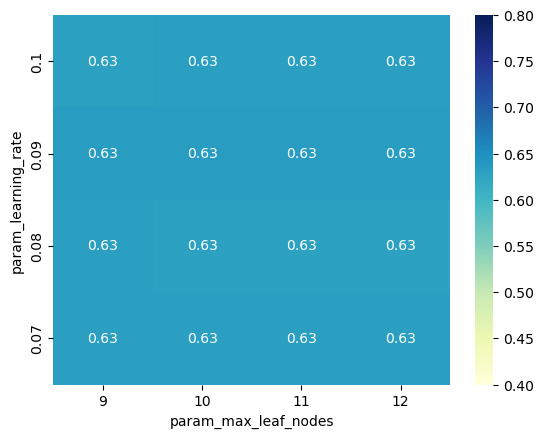

In [36]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

Mean Absolute Error:     2.704 +/- 0.174
Root Mean Squared Error: 3.706 +/- 0.224


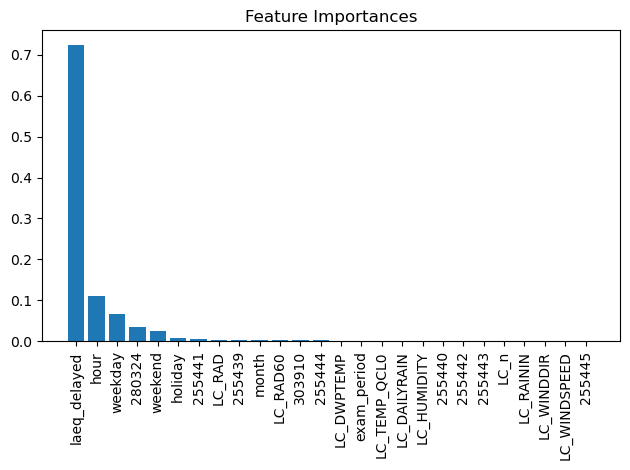

In [43]:
#run gradient boosting model and plot feature importances
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

    # Fit the model on the data
    model.fit(X, y)

    # Retrieve feature importances
    feature_importances = model.named_steps['gradientboostingregressor'].feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation='vertical')
    plt.tight_layout()
    plt.show()

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=11, learning_rate=0.09))
evaluate(gbrt_pipeline, X, y, cv=ts_cv)


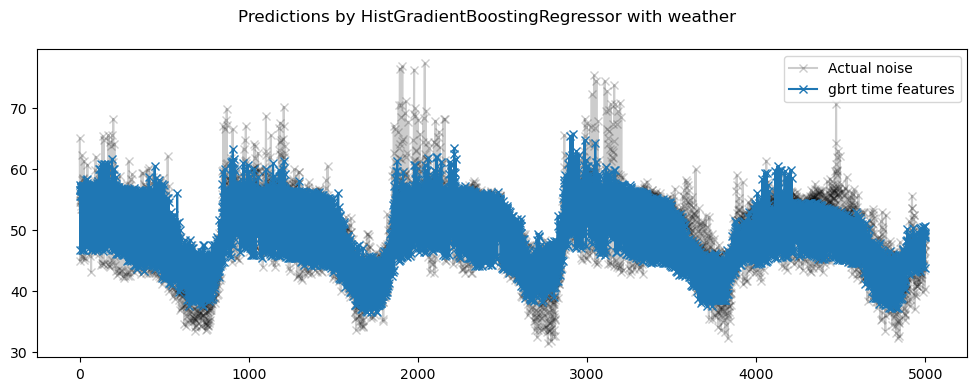

In [38]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-5000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


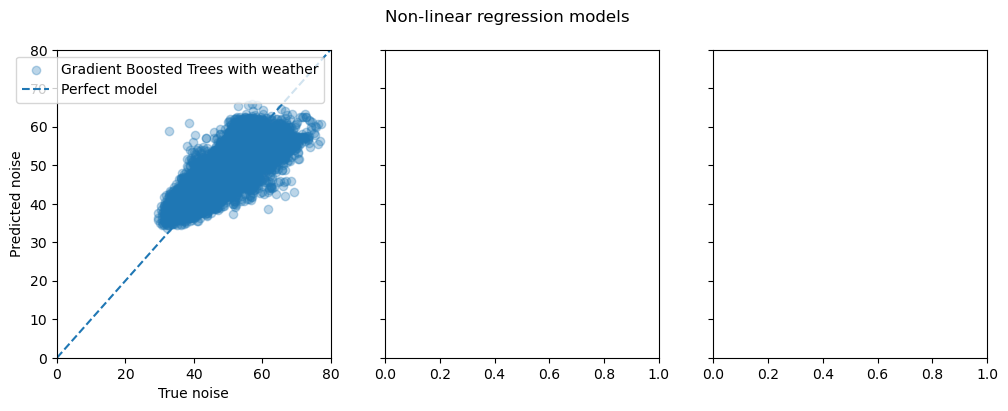

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

SHAPLEY value with cross validation
https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values
https://towardsdatascience.com/using-shap-with-cross-validation-d24af548fadc

In [91]:
def plot_shaply(pipeline_step):
    #this model calculates shapley values for all models previously introduced
    SHAP_values_per_fold = [] #-#-#

    for i in range(len(all_splits)):
        X_train=X.iloc[all_splits[i][0]]
        X_test=X.iloc[all_splits[i][1]]
        y_train=y.iloc[all_splits[i][0]]
        y_test=y.iloc[all_splits[i][1]]


        

        model = pipeline_step
        fit = model.fit(X_train, y_train)
        
        # Use SHAP to explain predictions
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)
        for SHAPs in shap_values:
            SHAP_values_per_fold.append(SHAPs) #-#-#

    #print(SHAP_values_per_fold)
    ix_training, ix_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in ts_cv.split(df):
        ix_training.append(fold[0]), ix_test.append(fold[1])
    #create new index for Shapley values
    new_index = [ix for ix_test_fold in ix_test for ix in ix_test_fold]
    #plot shapley values
    shap.summary_plot(np.array(SHAP_values_per_fold), X.reindex(new_index))

#Shapley values for gbrt_pipeline
plot_shaply(gbrt_pipeline.named_steps['gradientboostingregressor'])  

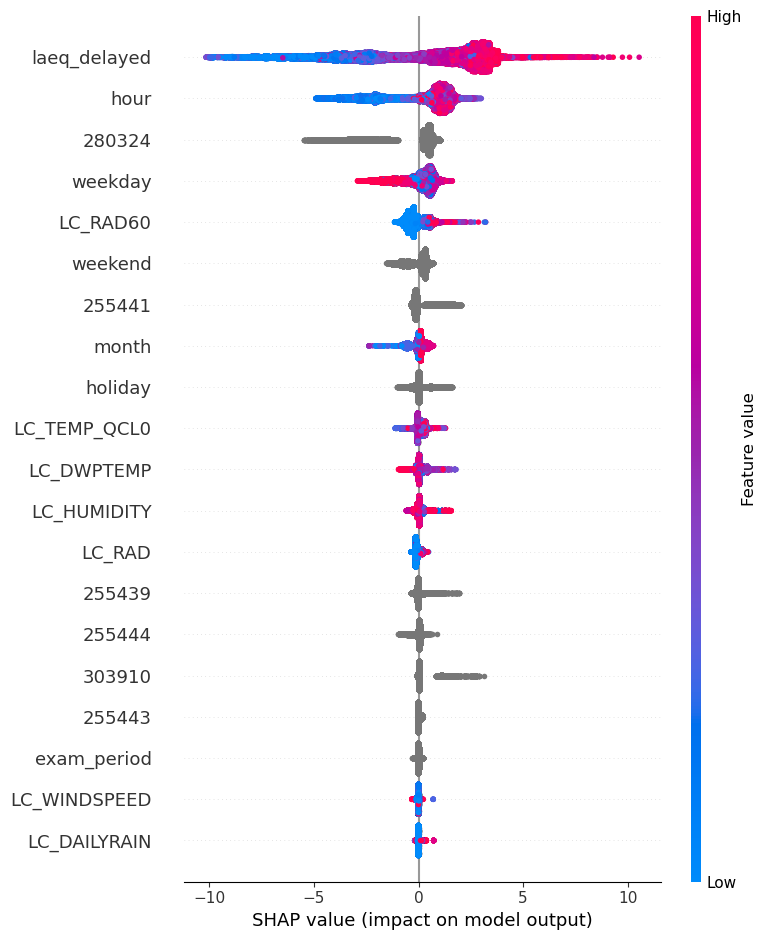

In [92]:
plot_shaply(gbrt_pipeline.named_steps['gradientboostingregressor'])

In [88]:
# explain the model's predictions using SHAP this is a great way of showing how different variables determine the prediction: even nice as a visualisation
explainer = shap.Explainer(gbrt_pipeline.named_steps['gradientboostingregressor'])
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])